**Author:** Rajeevkumar Yadav

**Description:** 

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM or GRU cells are implemented. 

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)


# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [25]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 20 



# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load stock prices from tcs.csv
- analyze data

In [26]:
# import all stock prices 
df = pd.read_csv("../input/simple3daymovtcs/simplemovtcs.csv", index_col = 0)
!ls
#df = pd.read_csv("../input/infosysdata/INFY.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
#print('\nnumber of different stocks: ', len(list(set(df.symbol))))
#print(list(set(df.symbol))[:10])

__notebook_source__.ipynb
<class 'pandas.core.frame.DataFrame'>
Index: 2271 entries, 2009-01-06 to nan
Data columns (total 6 columns):
Open         2250 non-null float64
High         2250 non-null float64
Low          2250 non-null float64
Close        2250 non-null float64
Adj Close    2250 non-null float64
Volume       2250 non-null float64
dtypes: float64(6)
memory usage: 124.2+ KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-06,249.500000,258.950002,245.566666,253.324997,217.177836,3093490.0
2009-01-07,256.000000,260.799998,243.475001,254.408330,218.106588,3293766.0
2009-01-09,256.500000,265.266663,241.308334,258.024999,221.207199,4858800.0
2009-01-12,255.941666,266.599996,242.450002,259.049998,222.085932,5138204.0
2009-01-13,252.708333,269.466665,246.383336,262.525004,225.065094,5862534.0


In [27]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
NaN,3082.299967,3090.299967,3012.049967,3024.733317,3024.733317,9.627270e+05
NaN,3043.299967,3069.033284,2994.399984,3021.833333,3021.833333,9.570057e+05
NaN,3034.299967,3067.333252,3000.066650,3030.066650,3030.066650,9.859337e+05
NaN,2990.966634,3028.933268,2961.566650,2991.016683,2991.016683,1.533827e+07
NaN,2945.566650,2965.199951,2904.166667,2921.549967,2921.549967,1.622578e+07


In [28]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2.250000e+03
mean,1713.734031,1732.926157,1694.284848,1713.659538,1618.539571,1.539785e+06
std,782.734974,789.037352,775.810531,782.050986,783.442169,1.053650e+06
min,227.491669,233.558334,223.391668,227.766668,197.642451,3.029390e+05
25%,1098.037496,1112.825002,1081.245840,1098.470805,984.119319,9.436994e+05
50%,1806.841675,1835.375000,1779.508301,1809.566691,1678.998433,1.265382e+06
75%,2477.141683,2498.279195,2451.200033,2475.320841,2381.502808,1.787782e+06
max,3158.683350,3221.283366,3121.116699,3164.833415,3164.833415,1.622578e+07


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2271 entries, 2009-01-06 to nan
Data columns (total 6 columns):
Open         2250 non-null float64
High         2250 non-null float64
Low          2250 non-null float64
Close        2250 non-null float64
Adj Close    2250 non-null float64
Volume       2250 non-null float64
dtypes: float64(6)
memory usage: 124.2+ KB


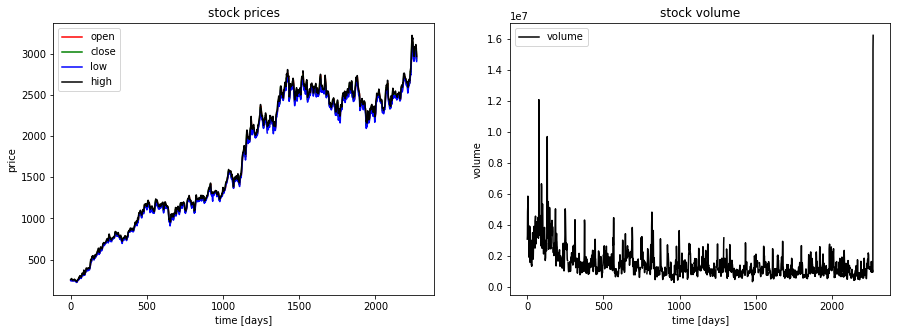

In [30]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
plt.plot(df.Low.values, color='blue', label='low')
plt.plot(df.High.values, color='black', label='high')
plt.title('stock prices')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df.Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [31]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df.copy()
#print(df_stock.columns)
#print(df_stock)
df_stock.drop(['Adj Close'],1,inplace=True)
df_stock.drop(['Volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock_norm.columns.values = ', cols)

# normalize stock
#my_df = pd.DataFrame(data=[4,5,6,7], index=range(0,4), columns=['A'])
#df_stock_norm = df_stock.copy()
#print(df_stock.isnull())
print(df_stock.head(3))
print(df_stock.dtypes)
print(np.any(np.isnan(df_stock)))
df_stock = df_stock.fillna(method='ffill')
print(np.any(np.isnan(df_stock)))

df_stock_norm = normalize_data(df_stock)



#df_stock_norm.all(np.isfinite(mat))
# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)



df_stock_norm.columns.values =  ['Open', 'High', 'Low', 'Close']
             Open        High         Low       Close
Date                                                 
2009-01-06  249.5  258.950002  245.566666  253.324997
2009-01-07  256.0  260.799998  243.475001  254.408330
2009-01-09  256.5  265.266663  241.308334  258.024999
Open     float64
High     float64
Low      float64
Close    float64
dtype: object
True
False
x_train.shape =  (1576, 19, 4)
y_train.shape =  (1576, 4)
x_valid.shape =  (225, 19, 4)
y_valid.shape =  (225, 4)
x_test.shape =  (450, 19, 4)
y_test.shape =  (450, 4)


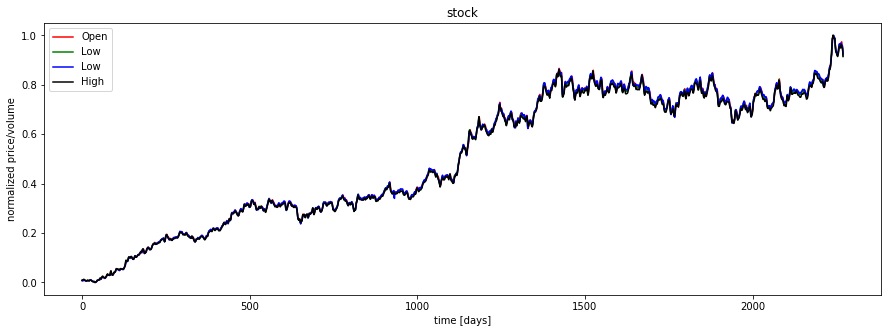

In [32]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.Open.values, color='red', label='Open')
plt.plot(df_stock_norm.Close.values, color='green', label='Low')
plt.plot(df_stock_norm.Low.values, color='blue', label='Low')
plt.plot(df_stock_norm.High.values, color='black', label='High')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [33]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.710771/1.051569
4.98 epochs: MSE train/valid = 0.000113/0.000216
9.96 epochs: MSE train/valid = 0.000152/0.000314
14.94 epochs: MSE train/valid = 0.000082/0.000146
19.92 epochs: MSE train/valid = 0.000079/0.000154
24.90 epochs: MSE train/valid = 0.000062/0.000115
29.89 epochs: MSE train/valid = 0.000051/0.000090
34.87 epochs: MSE train/valid = 0.000056/0.000108
39.85 epochs: MSE train/valid = 0.000079/0.000163
44.83 epochs: MSE train/valid = 0.000052/0.000105
49.81 epochs: MSE train/valid = 0.000044/0.000090
54.79 epochs: MSE train/valid = 0.000034/0.000061
59.77 epochs: MSE train/valid = 0.000030/0.000052
64.75 epochs: MSE train/valid = 0.000036/0.000076
69.73 epochs: MSE train/valid = 0.000046/0.000099
74.71 epochs: MSE train/valid = 0.000030/0.000059
79.70 epochs: MSE train/valid = 0.000034/0.000065
84.68 epochs: MSE train/valid = 0.000025/0.000043
89.66 epochs: MSE train/valid = 0.000112/0.000272
94.64 epochs: MSE train/valid = 0.000022/0.000048
99.

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

In [34]:
y_train.shape

(1576, 4)

correct sign prediction for close - open price for train/valid/test: 0.87/0.98/0.94


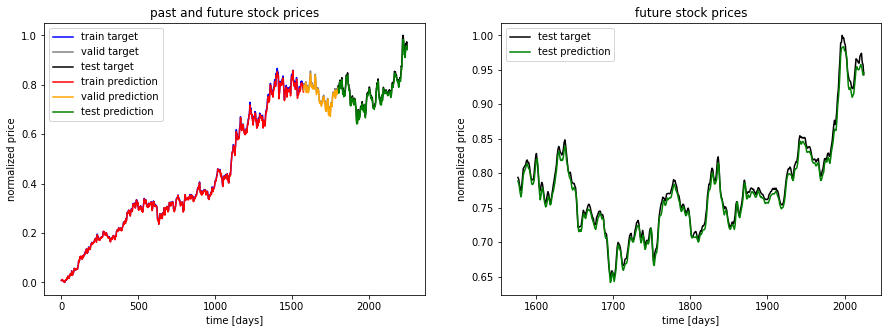

In [35]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

#y_train.to_csv(trainpred, sep=',')

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))
